---
title: cheg325 HW1 Q1
author: k.wodehouse
date: today
format: 
    html:
        self-contained: true
---


we need to do a few things to get this data read in from computer vision
- find the coordinates for the circles in the plot
- find the horizontal line
- subtract the horizontal line from the y values
- convert x and y pixels into the right values
- plot the figure from the text to verify it looks identical

I will use a hough transform to find the circles in the image, and another to find the line. since the image is computer generated finding the shapes will be extremely easy and the parameters will likely not have to be tuned at all to get fantastic results. 

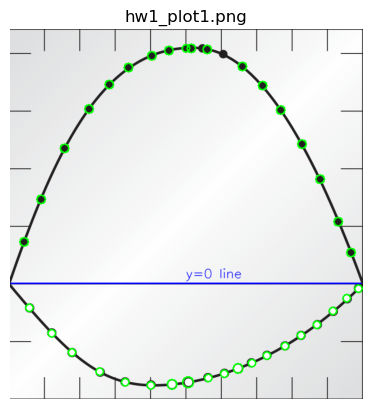

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

file = glob("*.png")[0]
img = cv2.imread(file)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=3,
                            param1=200, param2=20, minRadius=1, maxRadius=20)

edges = cv2.Canny(gray, 50, 150, apertureSize=3) 
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
longest_line = None
max_length = 0

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y1 - y2) < 5 and y1 > 50 and y1 < 500:  # near-horizontal line thats not at the top or the bottom of img
            length = abs(x2 - x1)
            if length > max_length:
                max_length = length
                longest_line = (x1, y1, x2, y2)
    if longest_line:
        cv2.line(img, (longest_line[0], longest_line[1]), (longest_line[2], longest_line[3]), (255, 0, 0), 2)
        cv2.putText(img, 'y=0 line', ((longest_line[0] + longest_line[2]) // 2, longest_line[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1, cv2.LINE_AA)

xcoords, ycoords = [],[]
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i, circle in enumerate(circles[0, :]):
        x, y = circle[0], circle[1]
        cv2.circle(img, (x, y), circle[2], (0, 255, 0), 2)

        y_0 = longest_line[1]
        y = y_0 - y
        xcoords.append(x)
        ycoords.append(y)

xcoords, ycoords = np.array(xcoords), np.array(ycoords)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(file)
plt.axis('off')
plt.show()

now we need to convert those pixel values into physical values from measuring pixels on the image

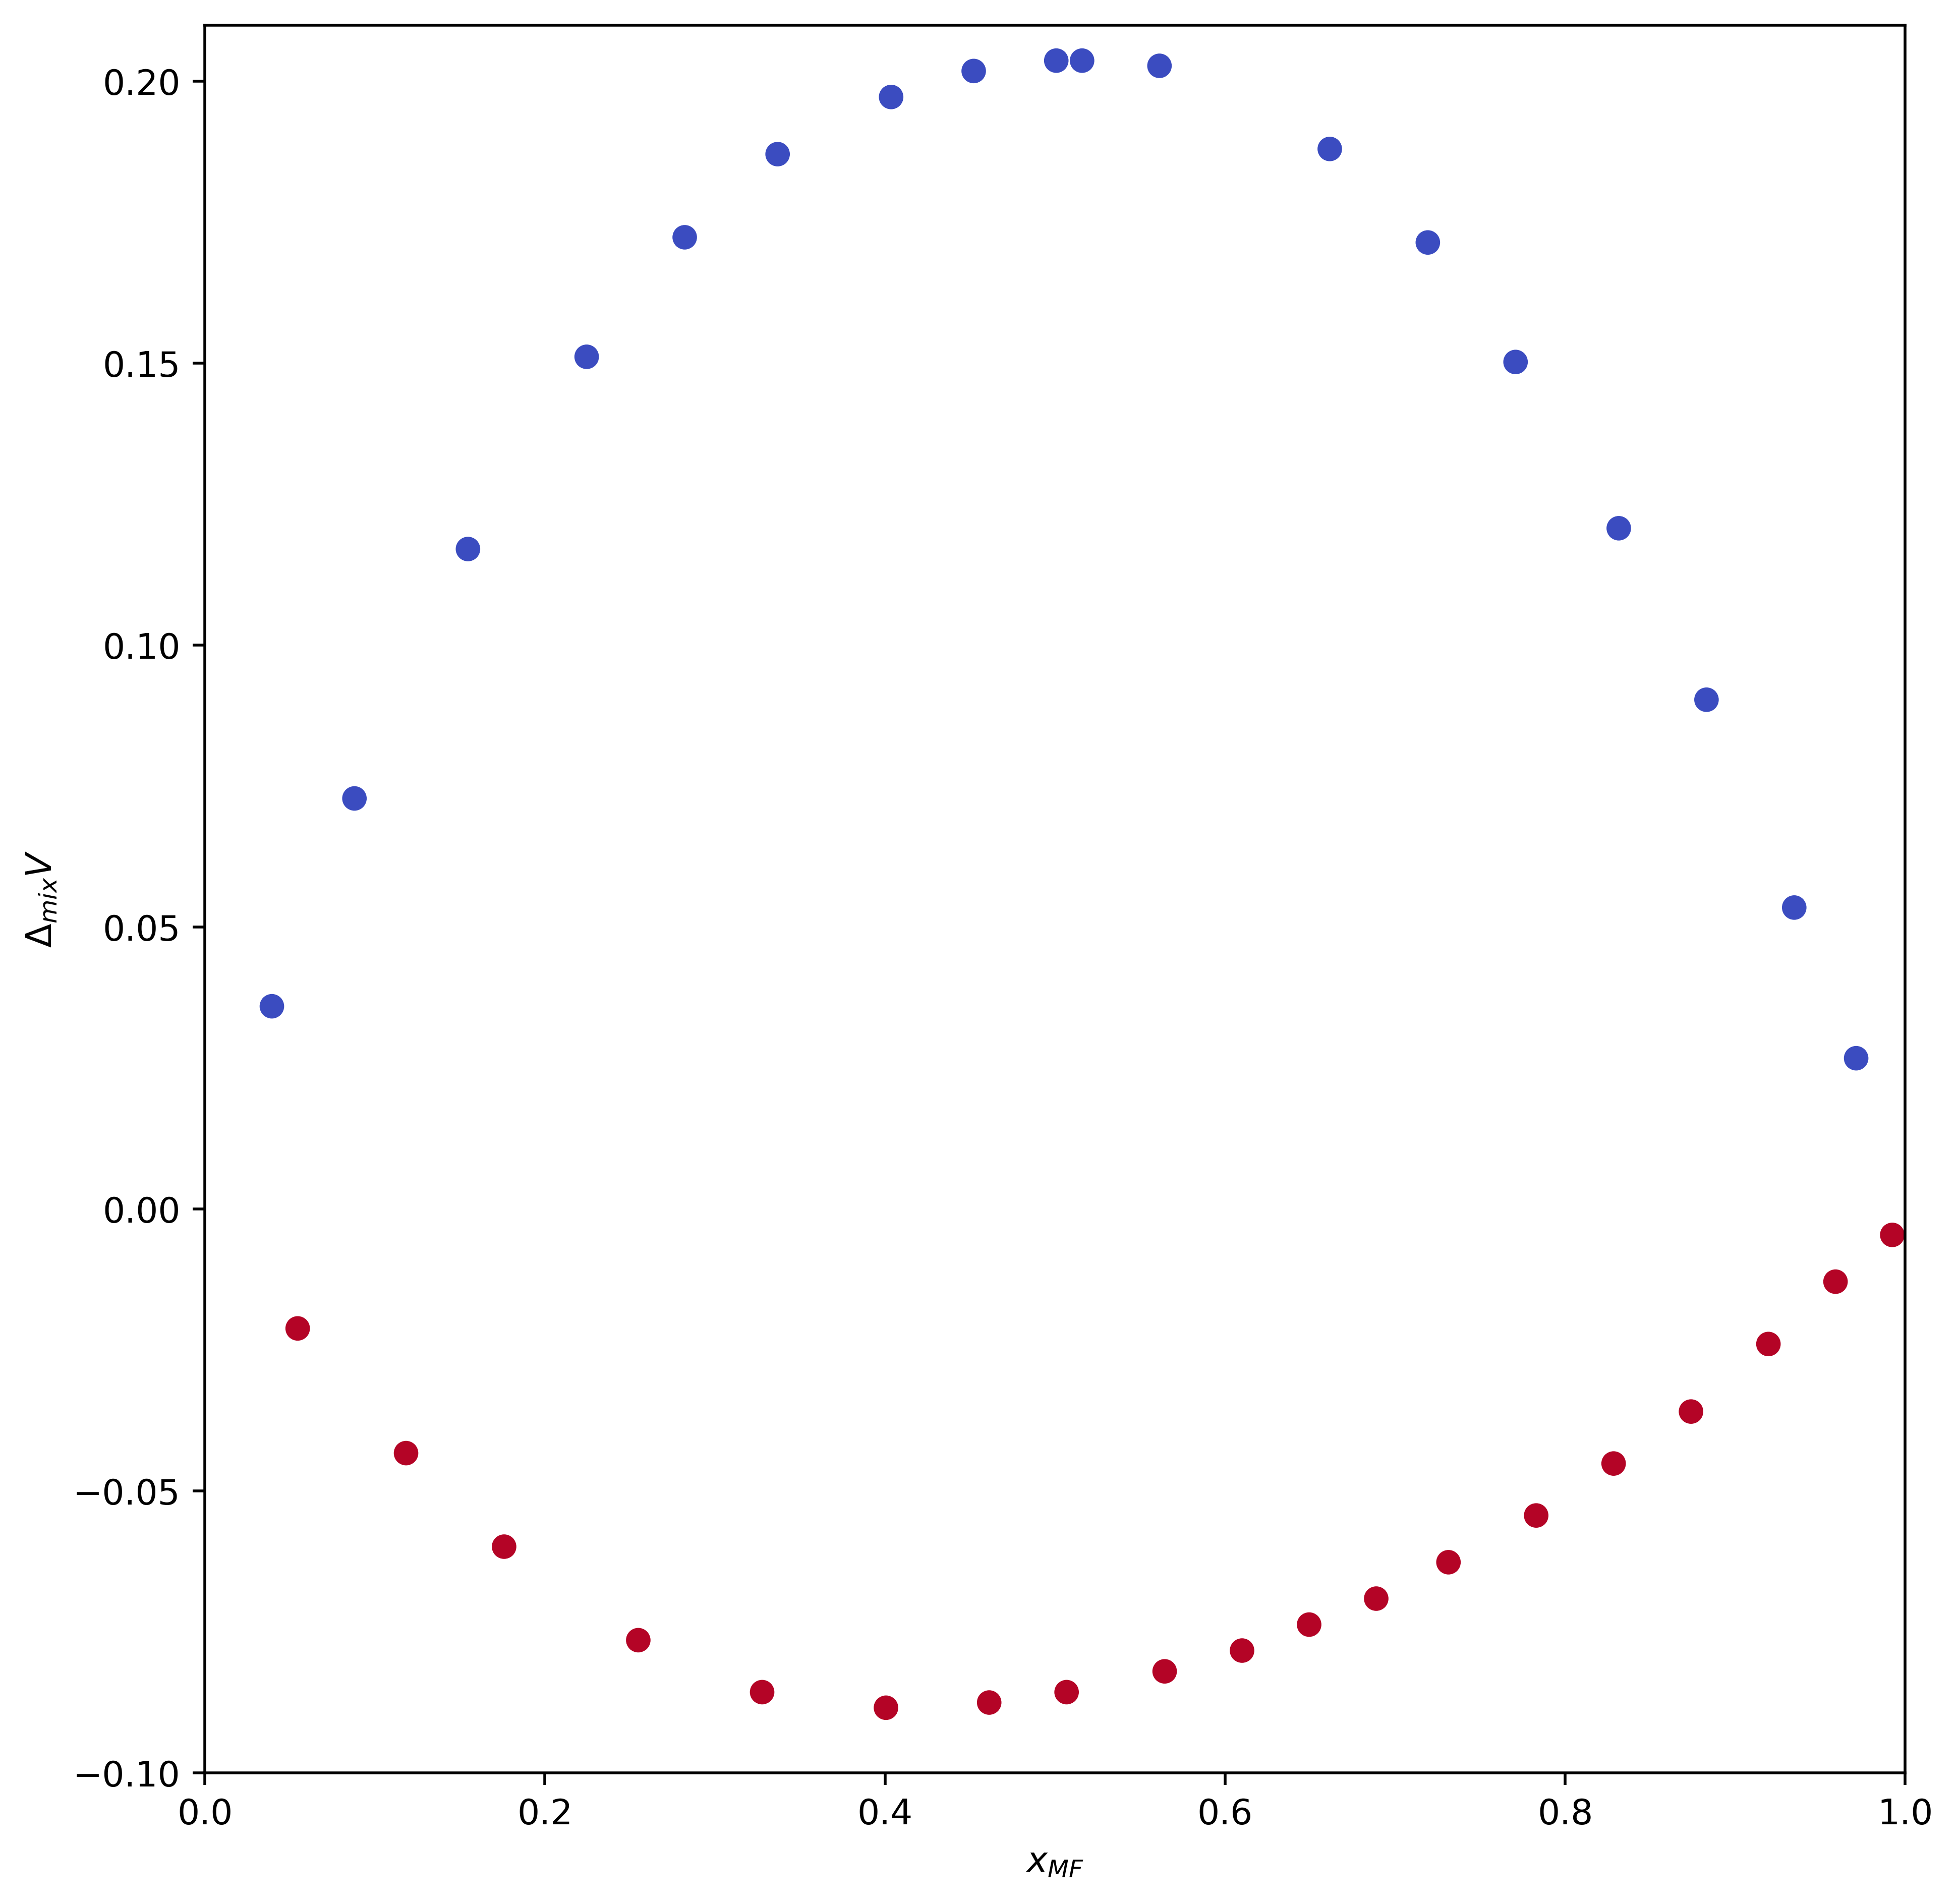

In [125]:
xcoords = xcoords / float(longest_line[2])
ycoords = ycoords * (0.2 / 434.0)

fig,ax = plt.subplots(figsize=(2.9*3,3.0*3), dpi=500, subplot_kw={'xlim':(0,1), 'ylim':(-0.1, 0.21)})
ax.scatter(xcoords, ycoords, c=ycoords<0, cmap='coolwarm')
ax.set(ylabel='$\Delta_{mix} {V}$', xlabel='$x_{MF}$');

now we need to split this up into two data sets--one for each mixture. anything greater than zero is the ethanol mixture and anything below zero is the mathanol mixture

In [126]:
indices = np.argsort(xcoords)
x_sorted, y_sorted = xcoords[indices], ycoords[indices]

x_mfe, y_mfe = x_sorted[y_sorted > 0], y_sorted[y_sorted > 0]
x_mfm, y_mfm = x_sorted[y_sorted < 0], y_sorted[y_sorted < 0]

## for MF + methanol mixture first
note the naming convention there `x_mfm` is `x_mf` in the `methanol` mixture

also the 0.06278 needs to be unit converted!

In [127]:
vmf = 0.06278 * 1000
vm = 0.04073 * 1000 

vmix = y_mfm
dydx = np.gradient(y_mfm) / np.gradient(x_mfm)

pmv_m = vmix - (x_mfm * dydx) + vm
pmv_mf = vmix + ((1-x_mfm) * dydx) + vmf

In [128]:
import pandas as pd
df = pd.DataFrame({
	'partial molar volume methanol': pmv_m,
	'partial molar volume methyl-formate': pmv_mf
}, index=x_mfm)
df.index.name = 'x_MF'
df

,partial molar volume methanol,partial molar volume methyl-formate
x_MF,,
0.054628,40.727762,62.430691
0.118361,40.724424,62.455553
0.176024,40.712857,62.519908
0.254932,40.696857,62.576793
0.327769,40.671244,62.638996
0.400607,40.647051,62.683247
0.461305,40.630434,62.706465
0.506829,40.617124,62.720716
0.564492,40.607636,62.729092


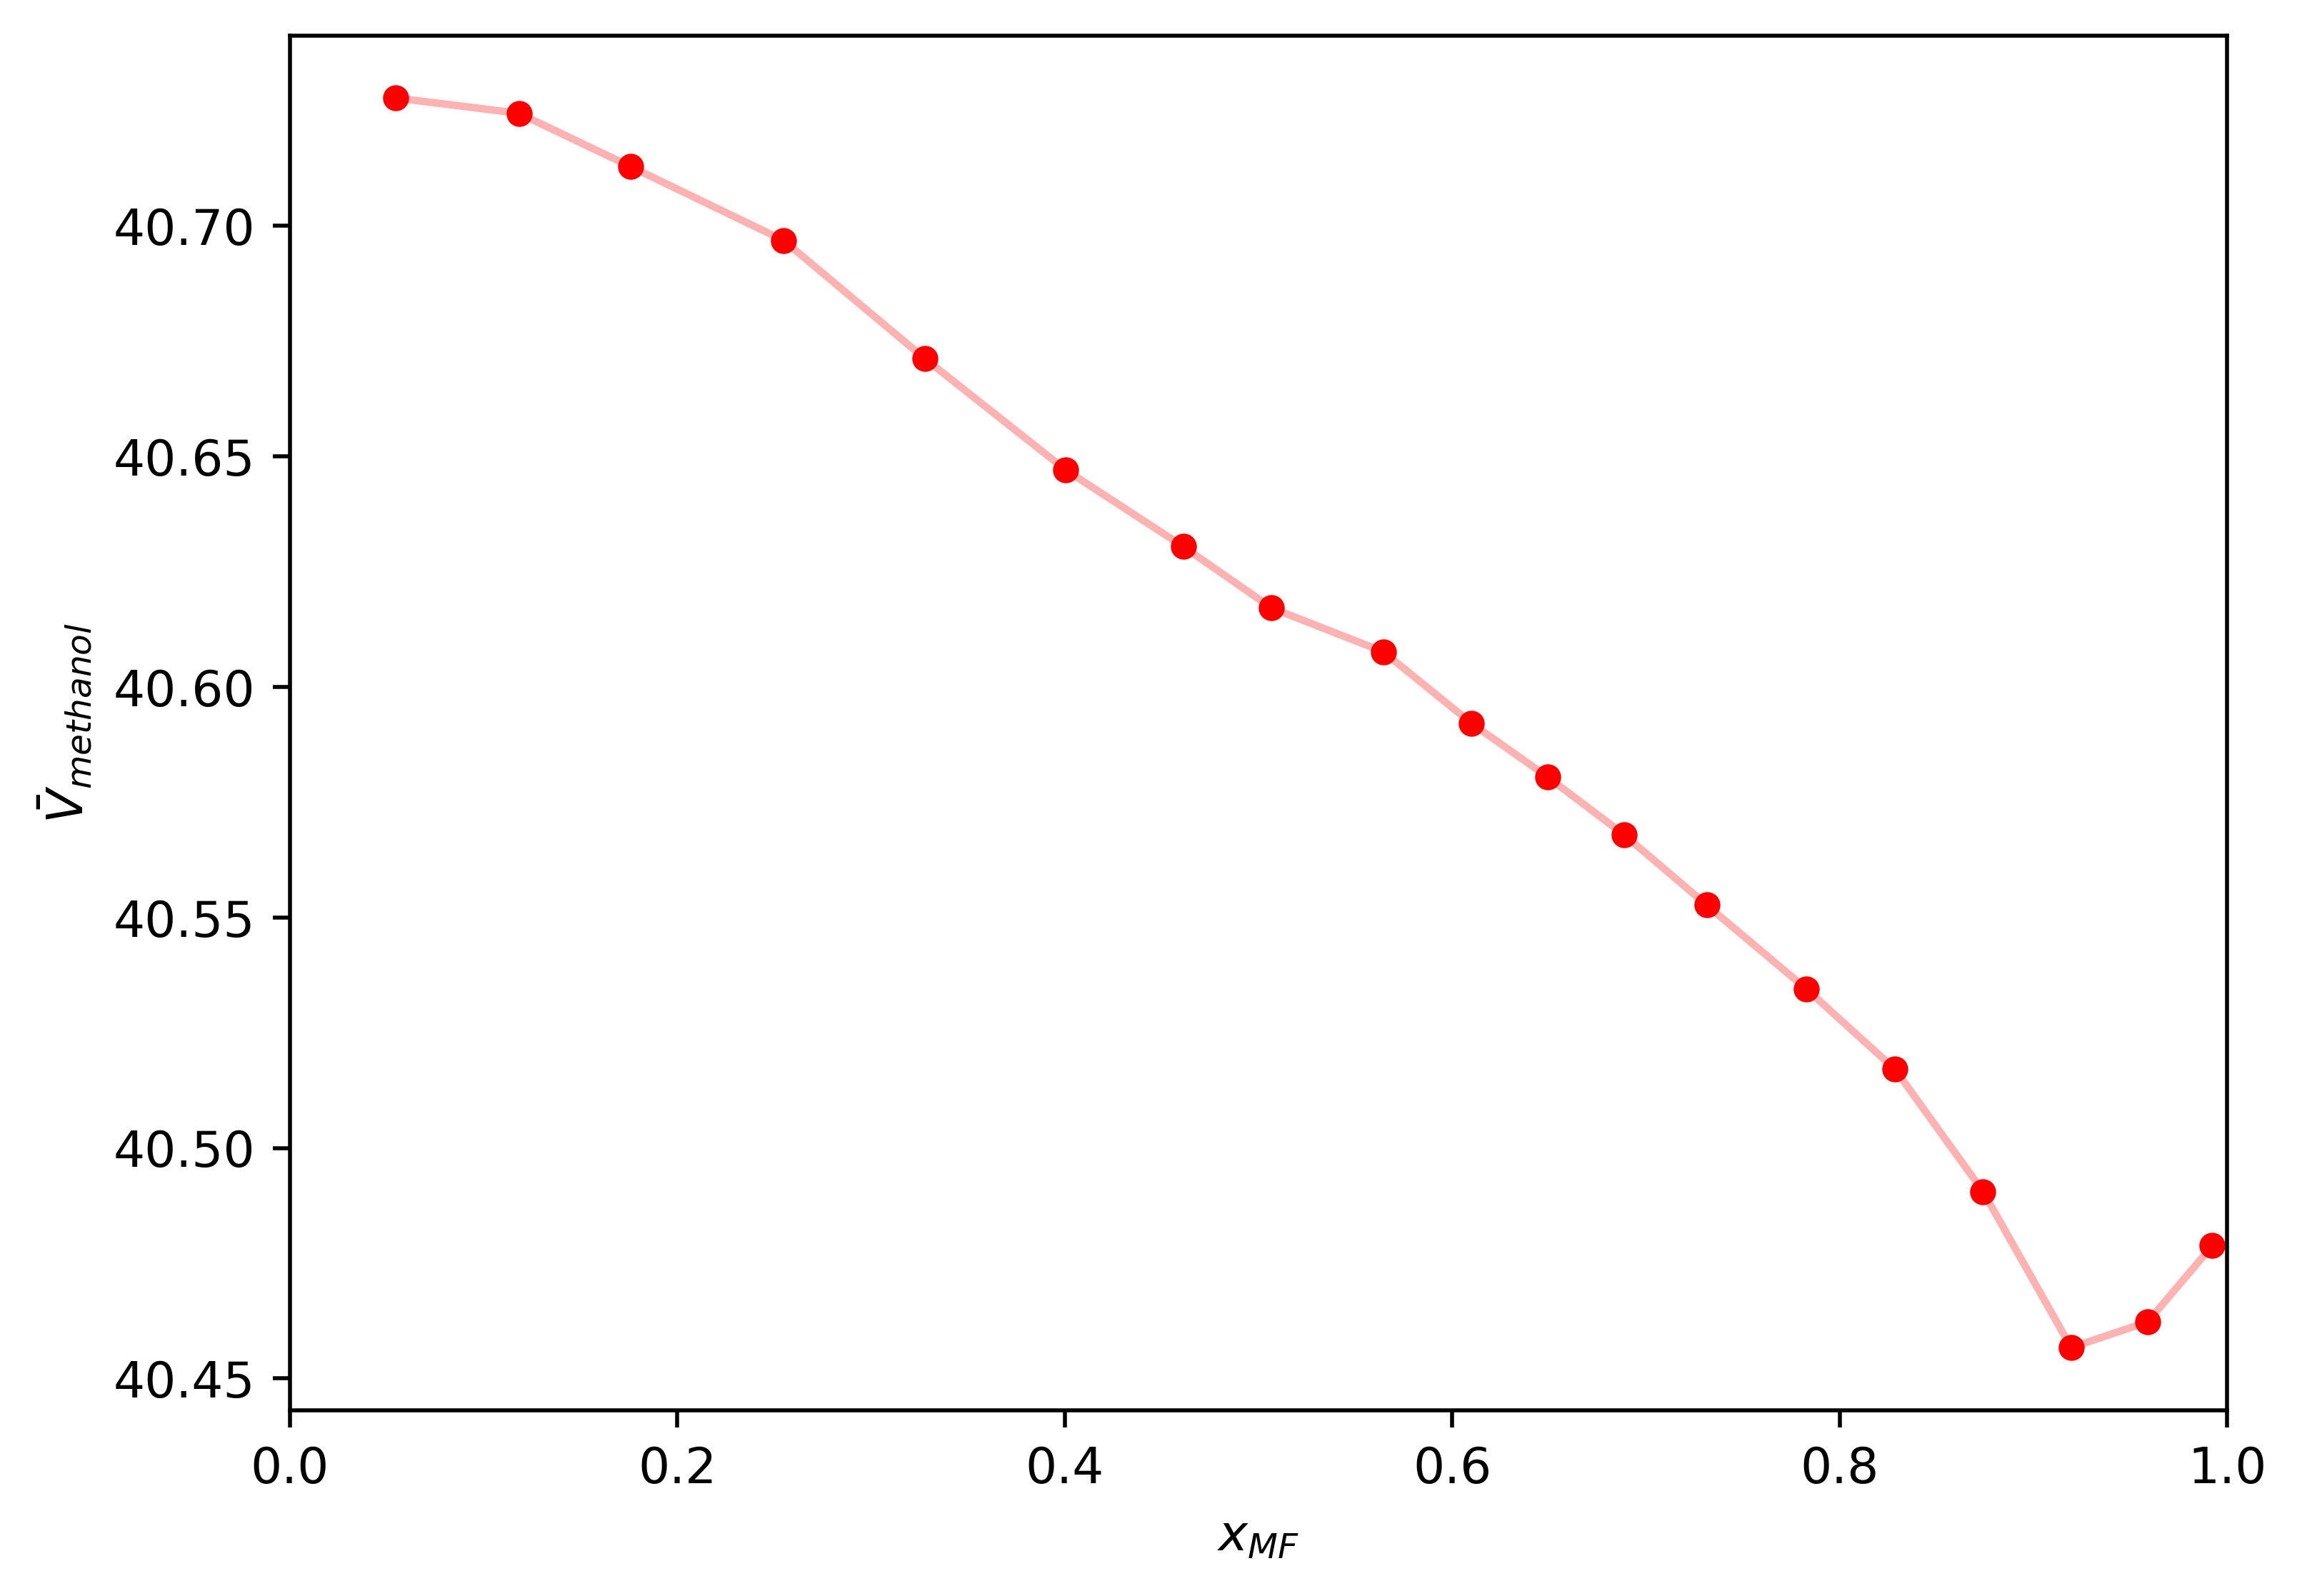

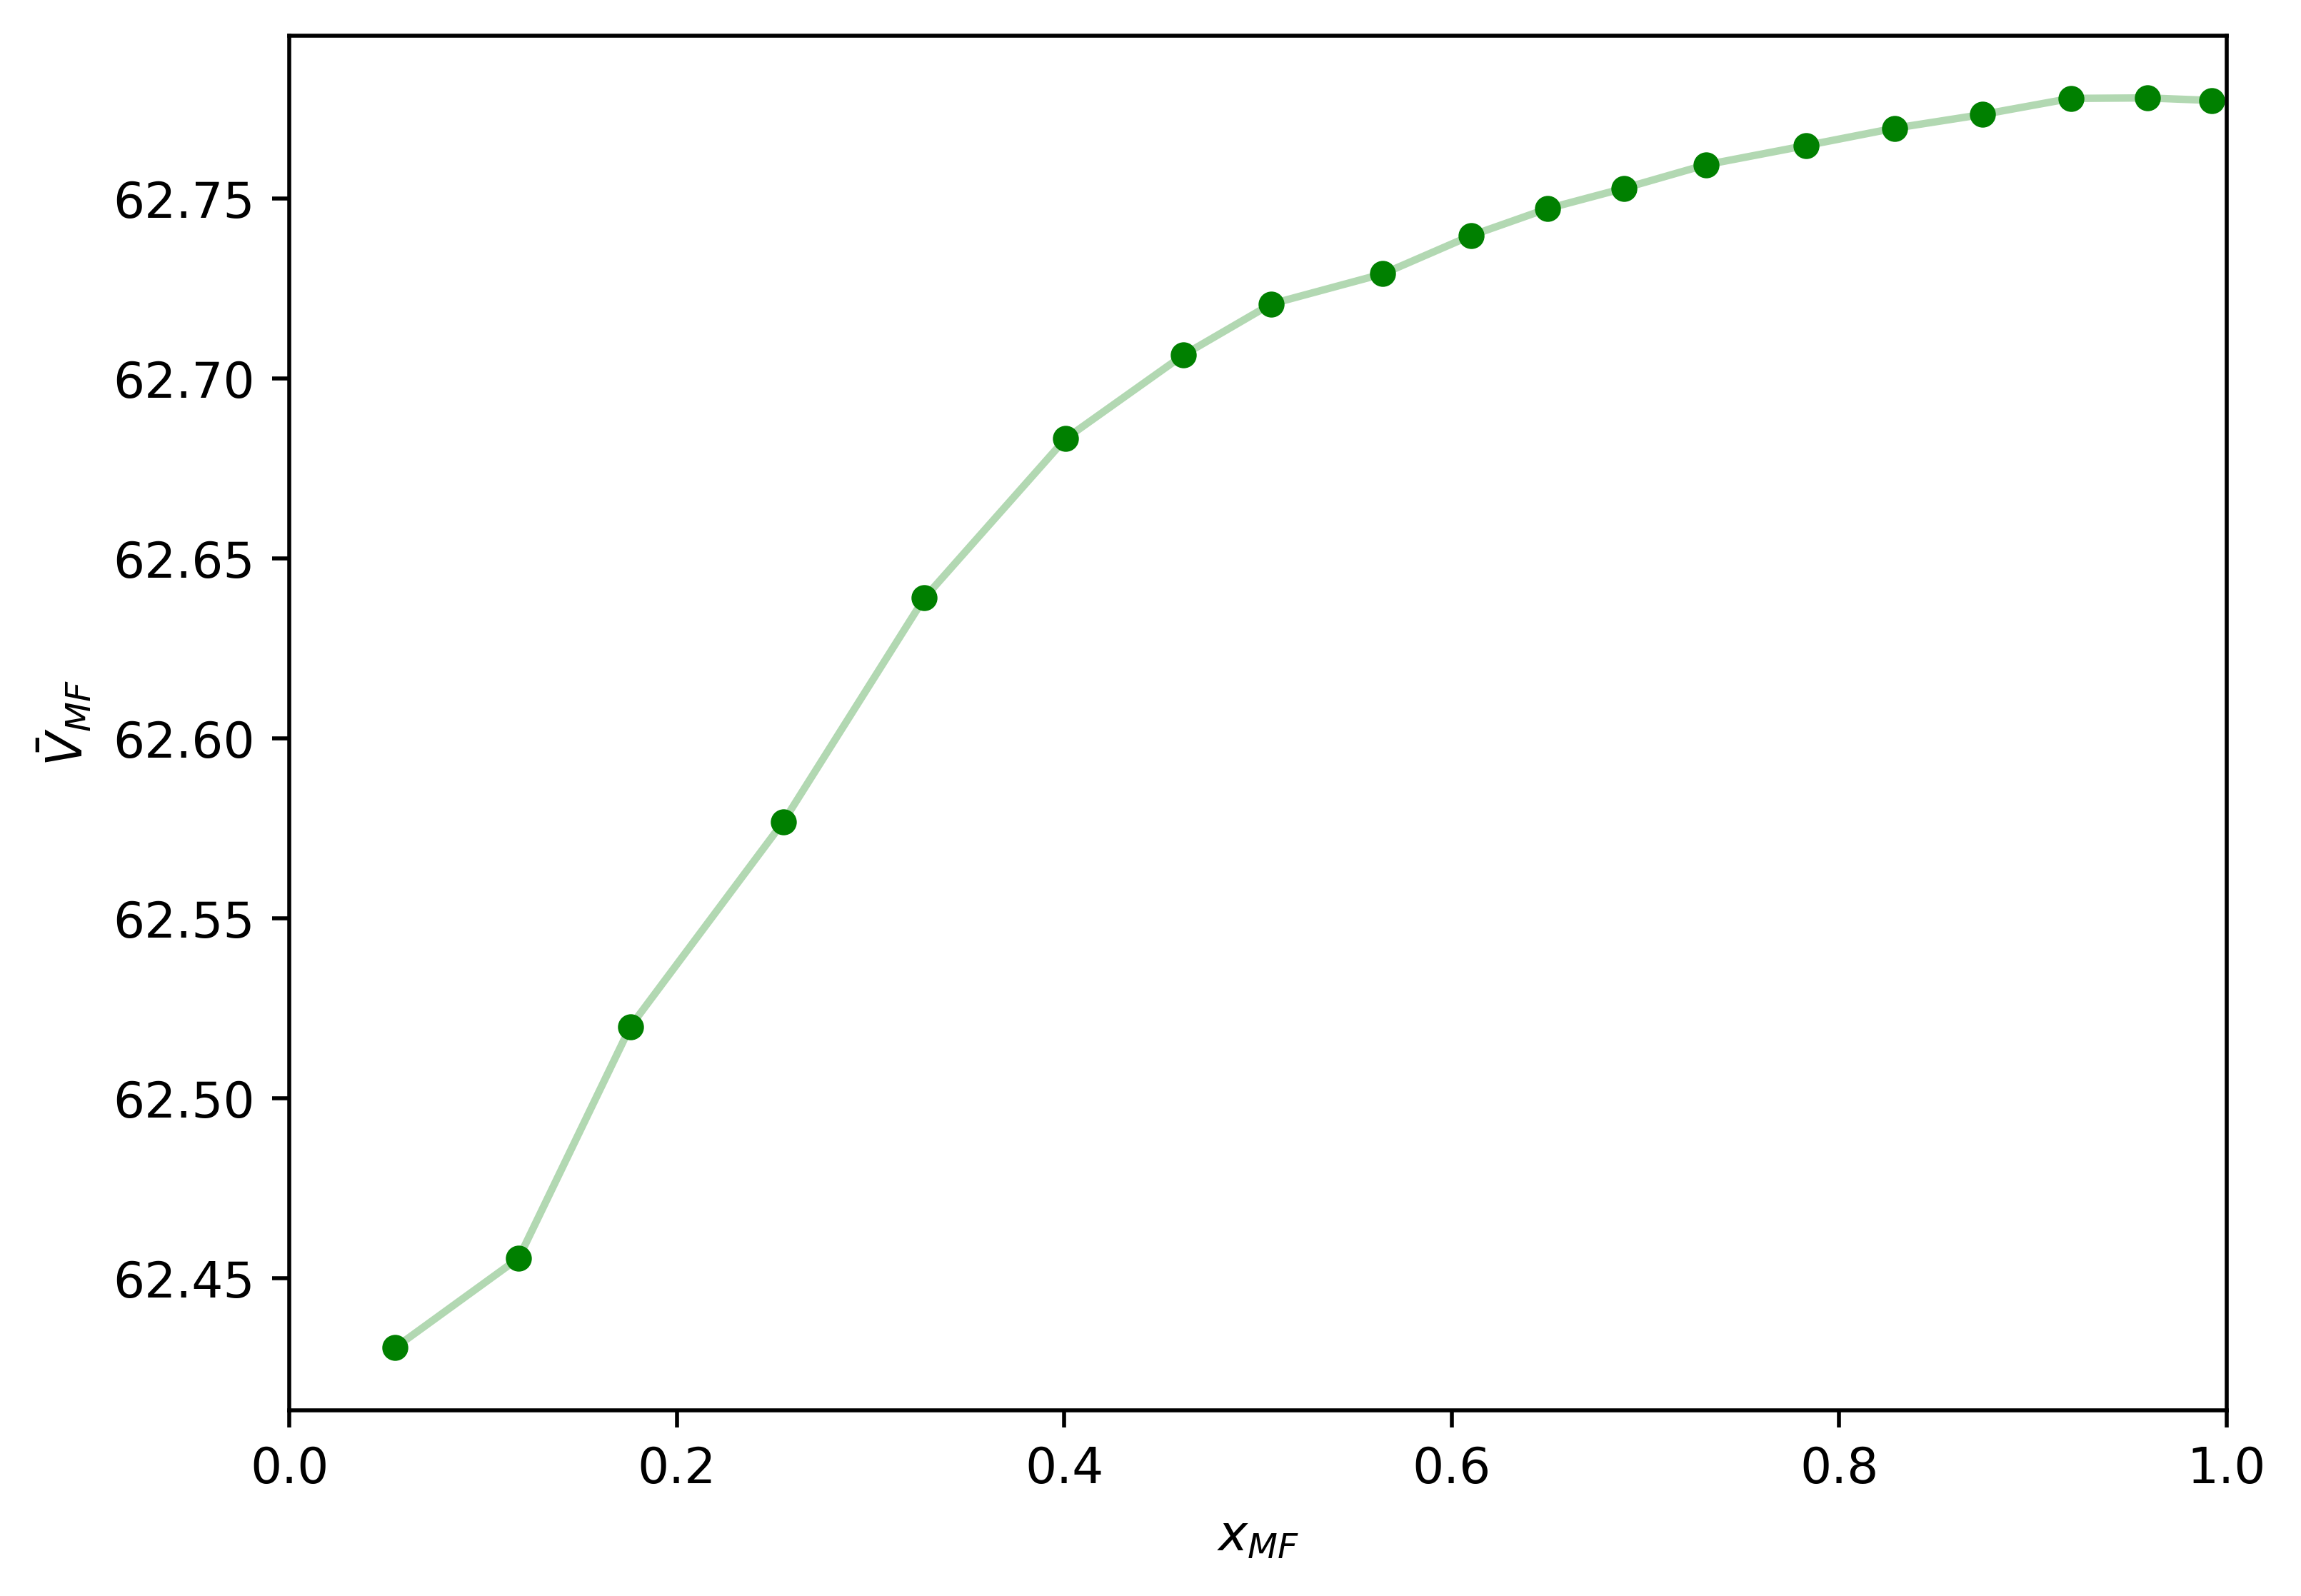

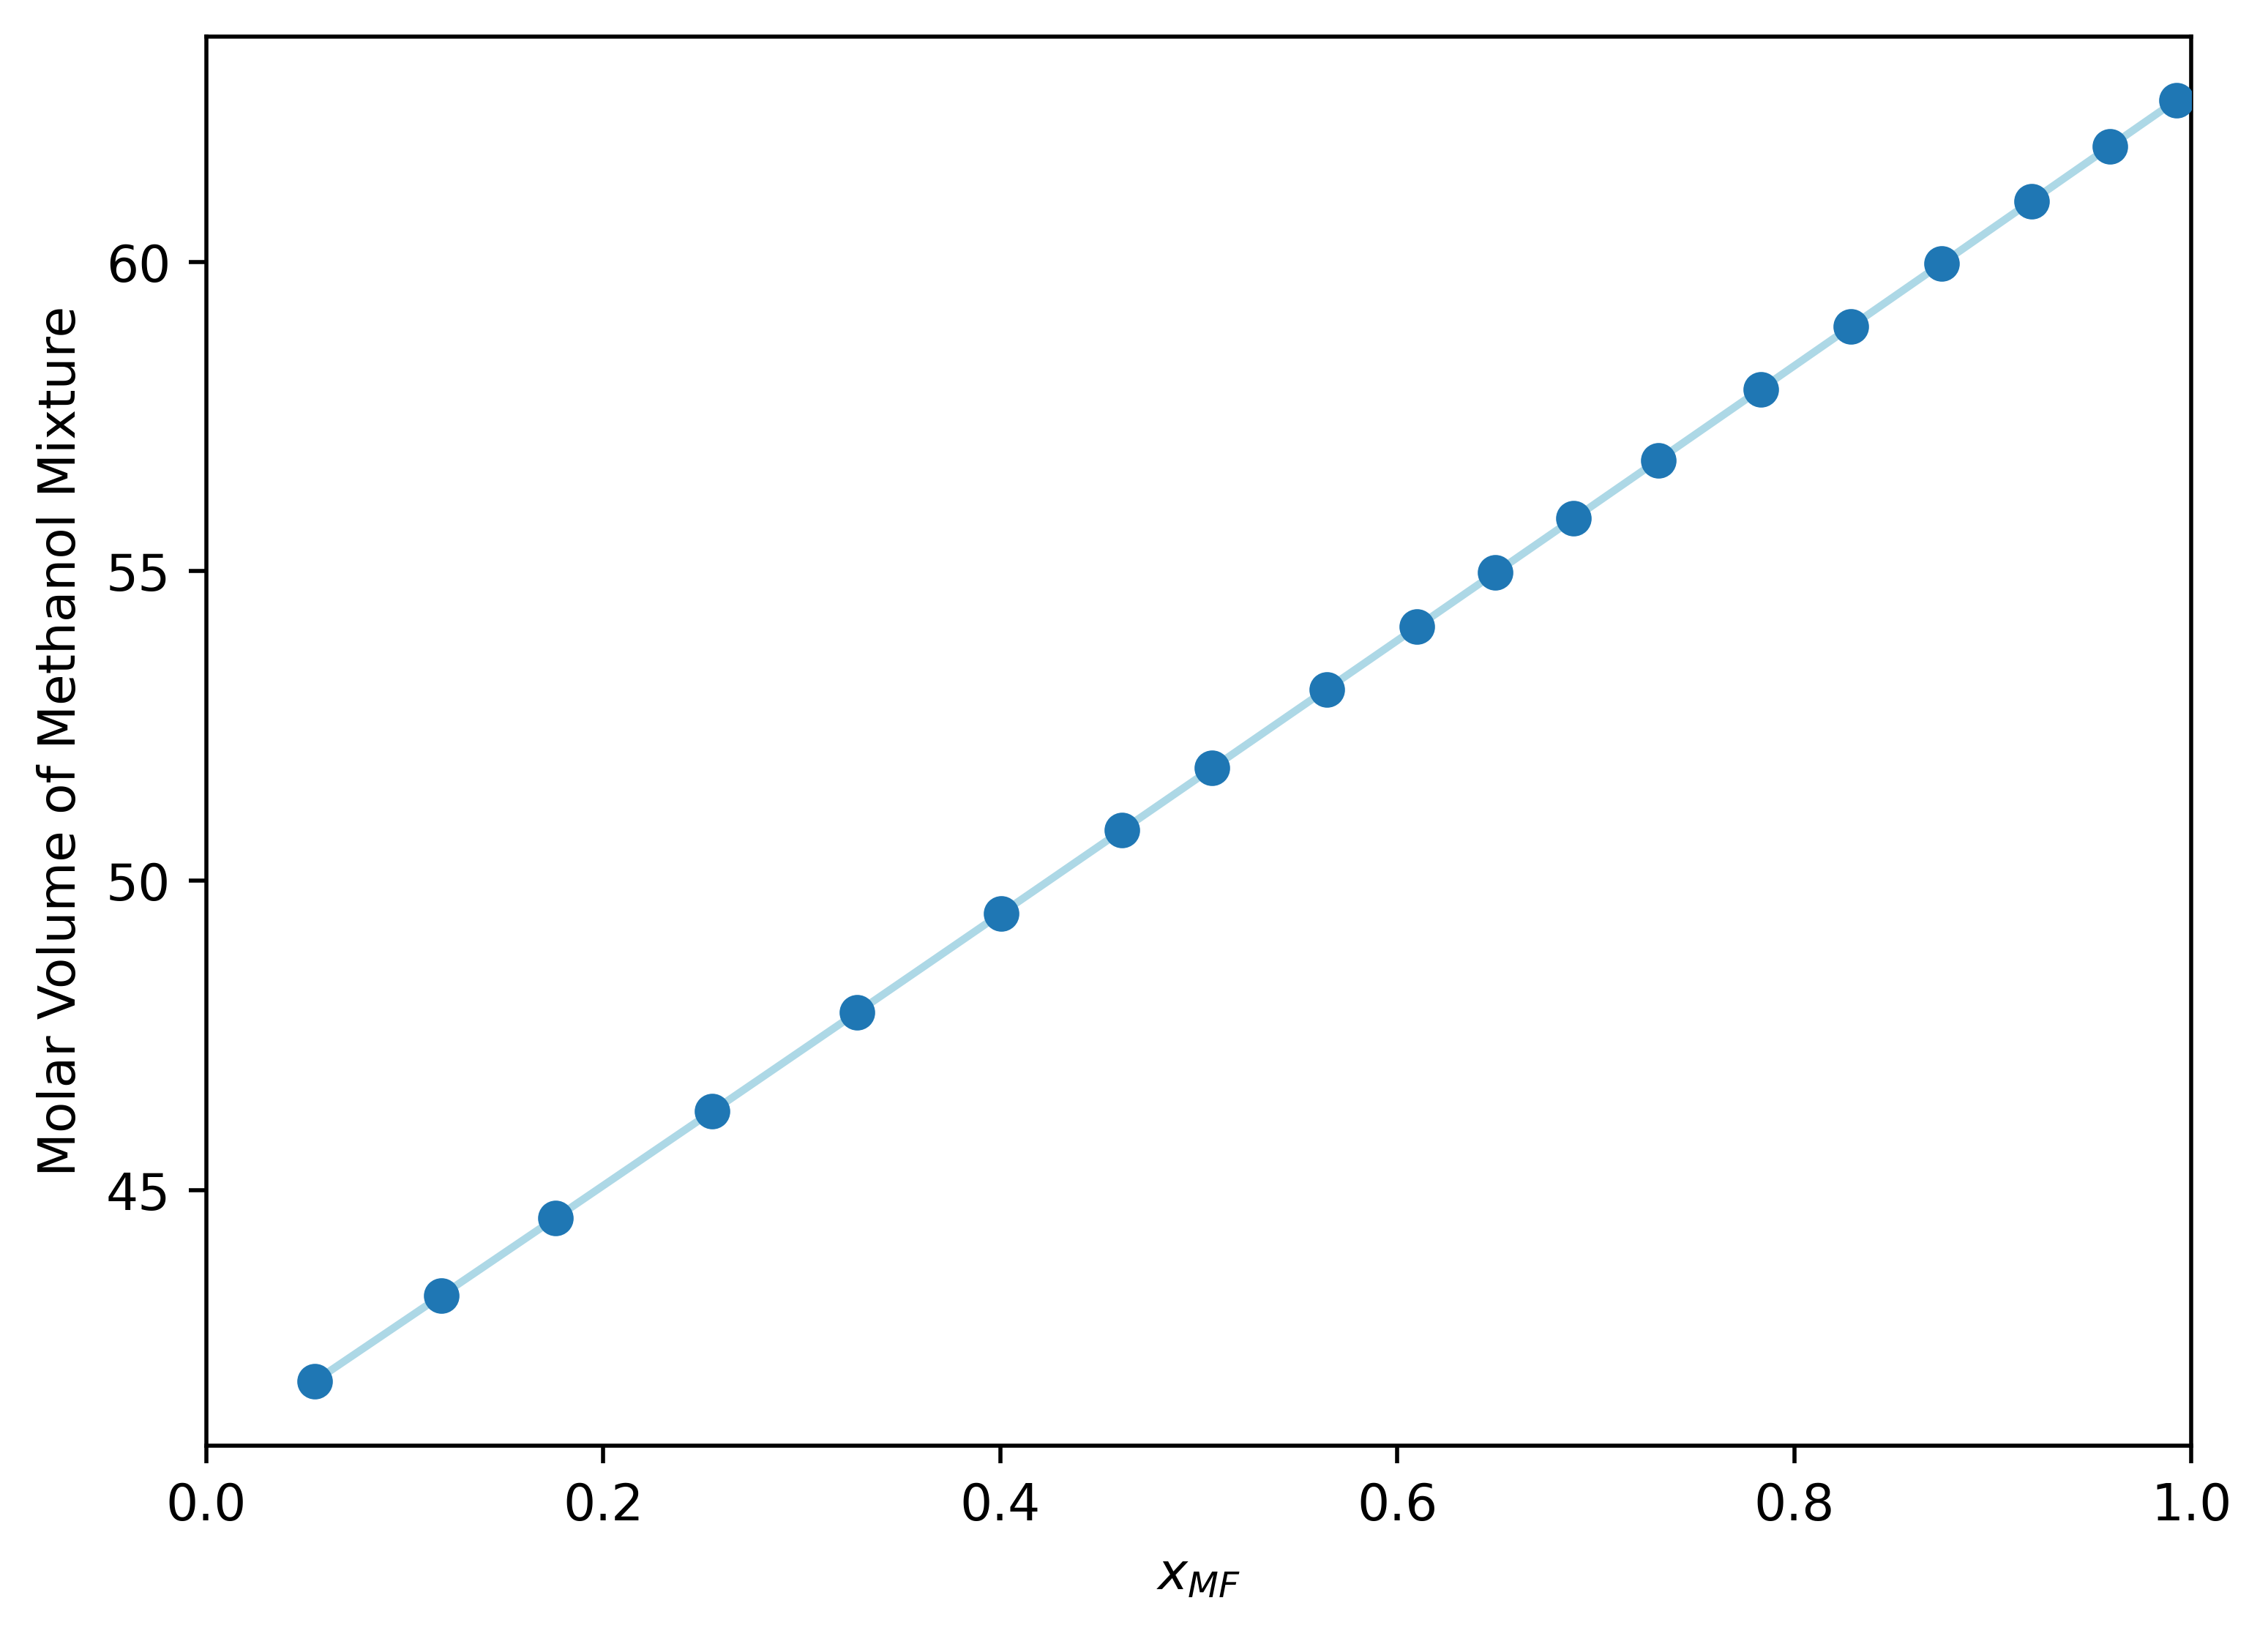

In [129]:
dpi=500
fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"$\\bar{V}_{methanol}$", 'xlim':(0,1)})
ax.scatter(x_mfm, pmv_m, c='red', s=18)
ax.plot(x_mfm, pmv_m, zorder=10, c='red', alpha=0.3);

fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"$\\bar{V}_{MF}$", 'xlim':(0,1)})
ax.scatter(x_mfm, pmv_mf, c='green', s=18)
ax.plot(x_mfm, pmv_mf, zorder=10, c='green', alpha=0.3);

fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"Molar Volume of Methanol Mixture", 'xlim':(0,1)})
V = x_mfm * pmv_mf + (1-x_mfm) * pmv_m
ax.plot(x_mfm, V, c='lightblue')
ax.scatter(x_mfm, V, zorder=10);

## now for the ethanol mixture

In [130]:
vmf = 0.06278 * 1000
ve = 0.05868 * 1000

vmix = np.array(y_mfe)
dydx = np.gradient(y_mfe) / np.gradient(x_mfe)

pmv_e = vmix - (x_mfe * dydx) + ve
pmv_mf = ( (vmix - (1-x_mfe)*(pmv_e - ve)) / x_mfe ) + vmf

df = pd.DataFrame({
	'partial molar volume ethanol': pmv_e,
	'partial molar volume methyl-formate': pmv_mf
}, index=x_mfe)
df.index.name = 'x_MF'
df

,partial molar volume ethanol,partial molar volume methyl-formate
x_MF,,
0.039454,58.685991,63.545207
0.088012,58.690914,63.494189
0.154780,58.708264,63.381895
0.224583,58.733720,63.267558
0.282246,58.762003,63.182105
0.336874,58.798041,63.103030
0.403642,58.825622,63.053490
0.452200,58.851803,63.018234
0.500759,58.869203,62.998126


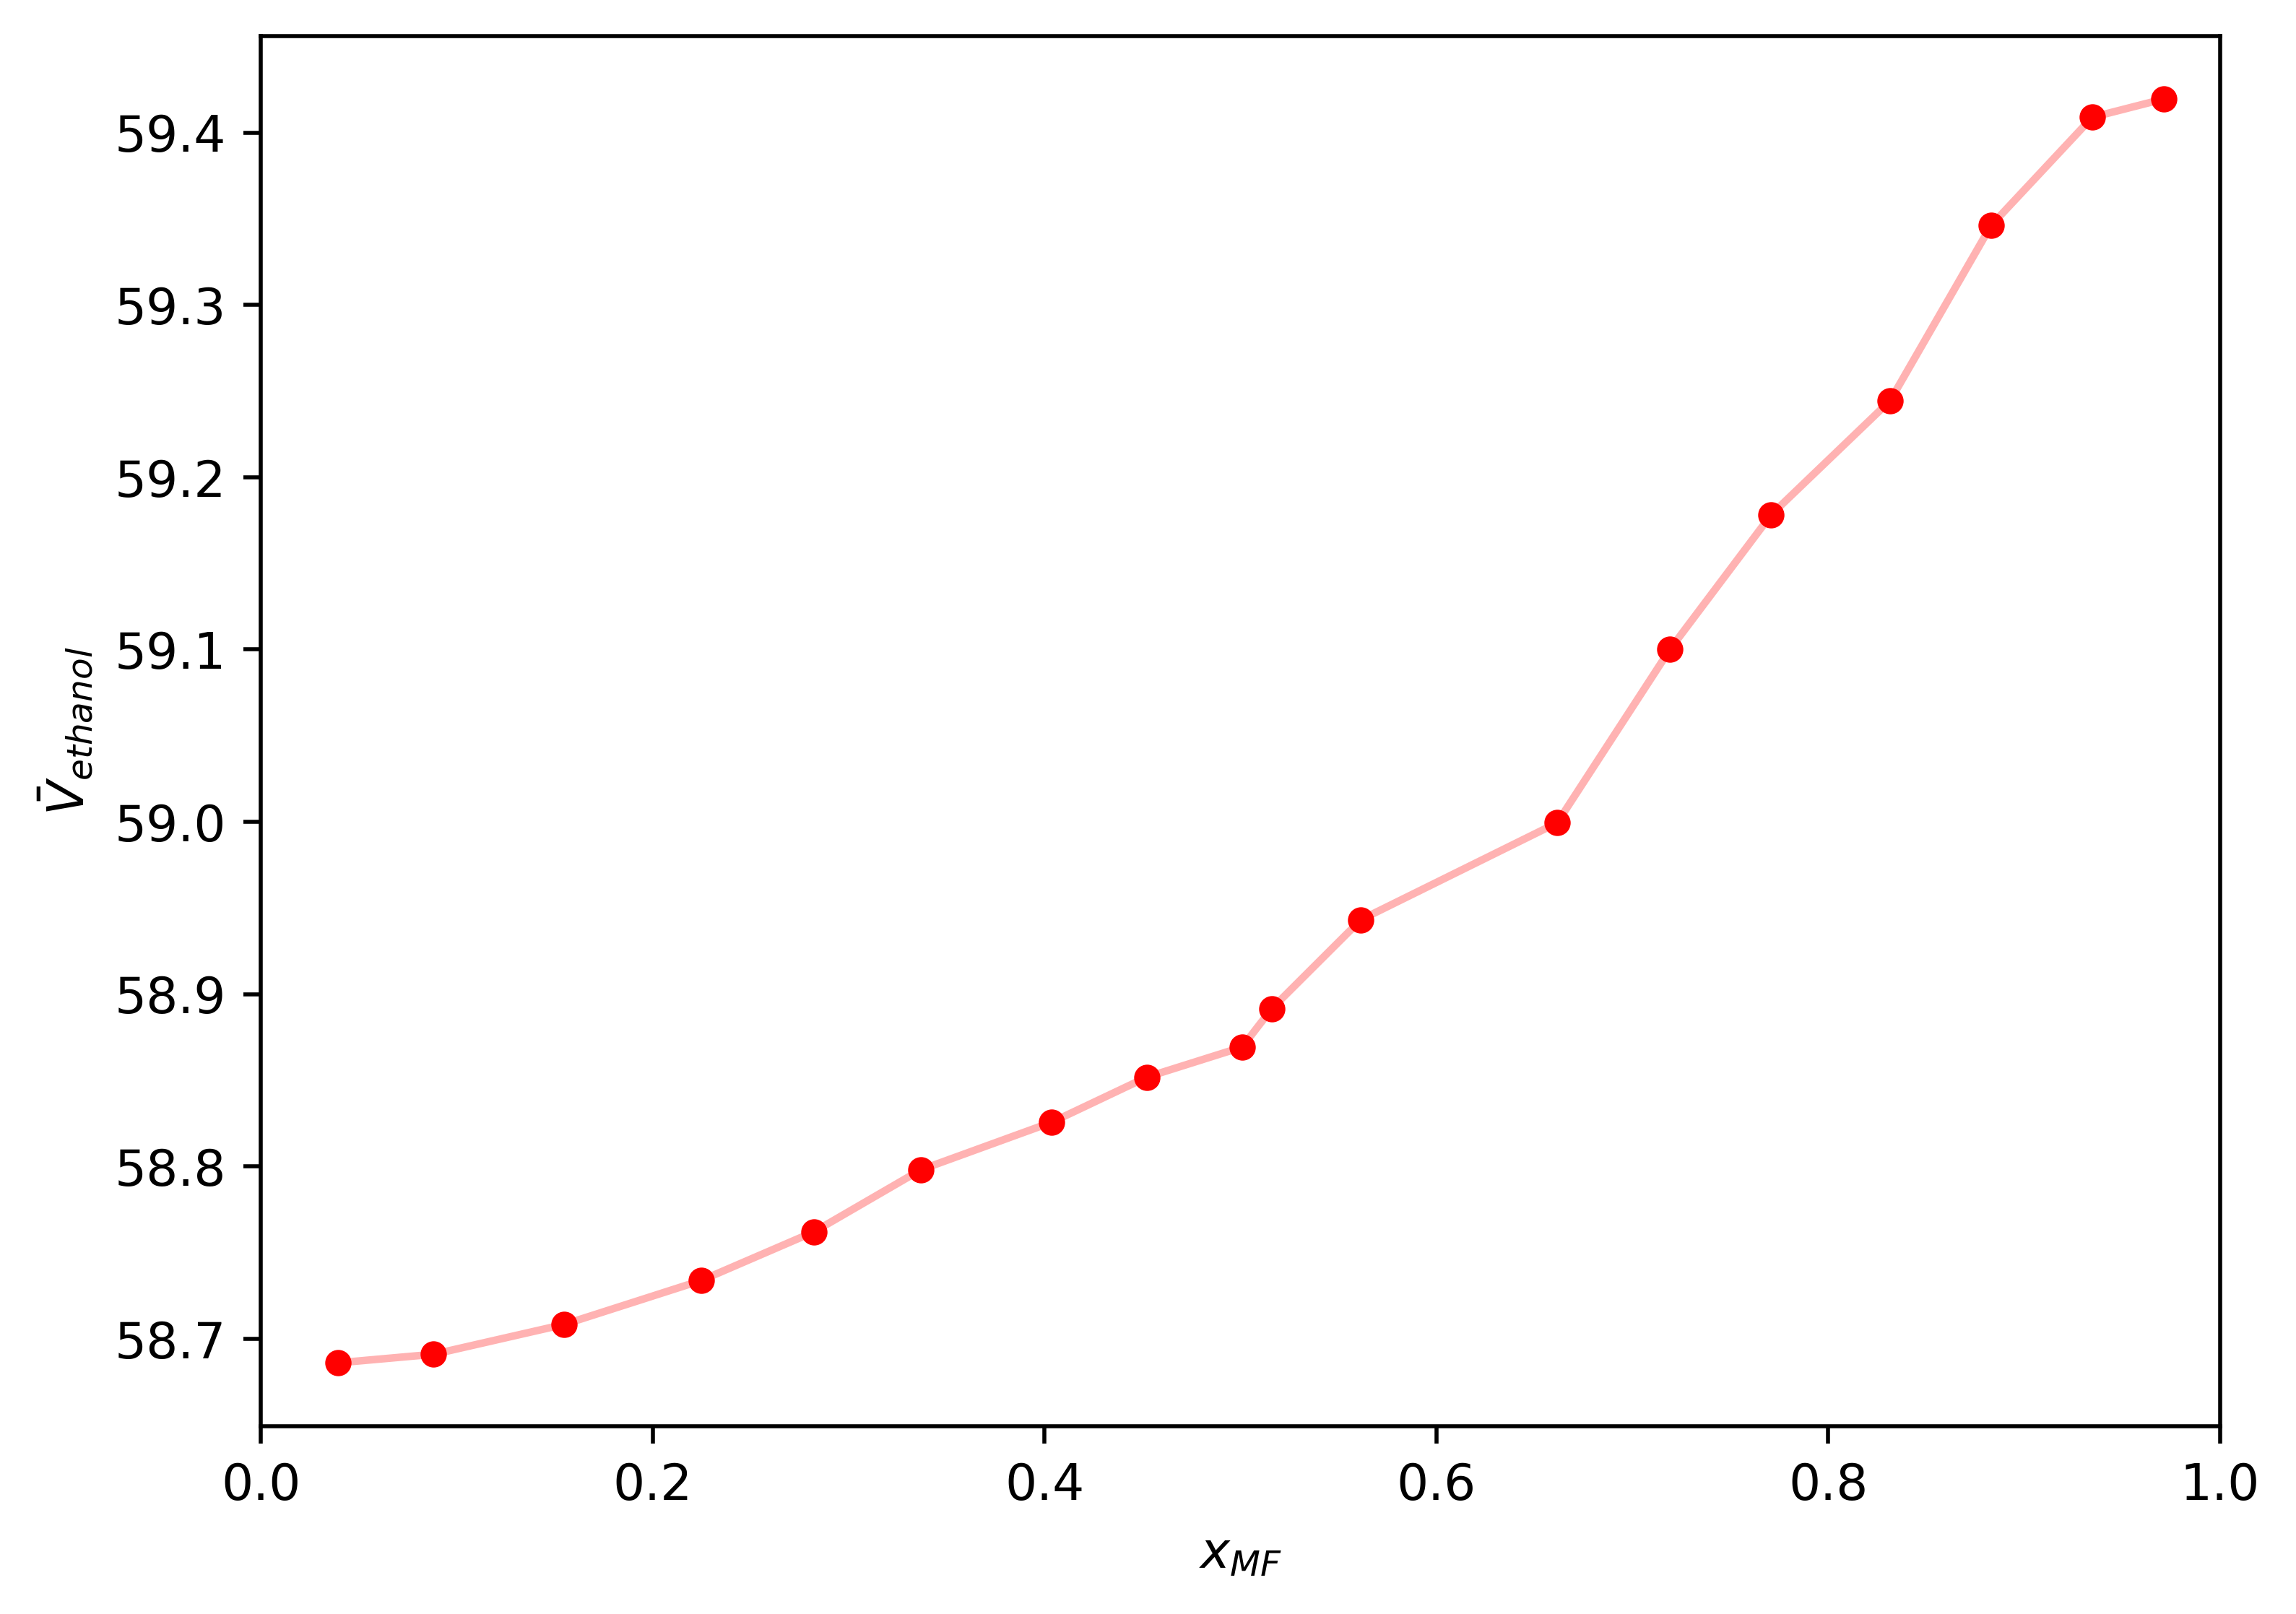

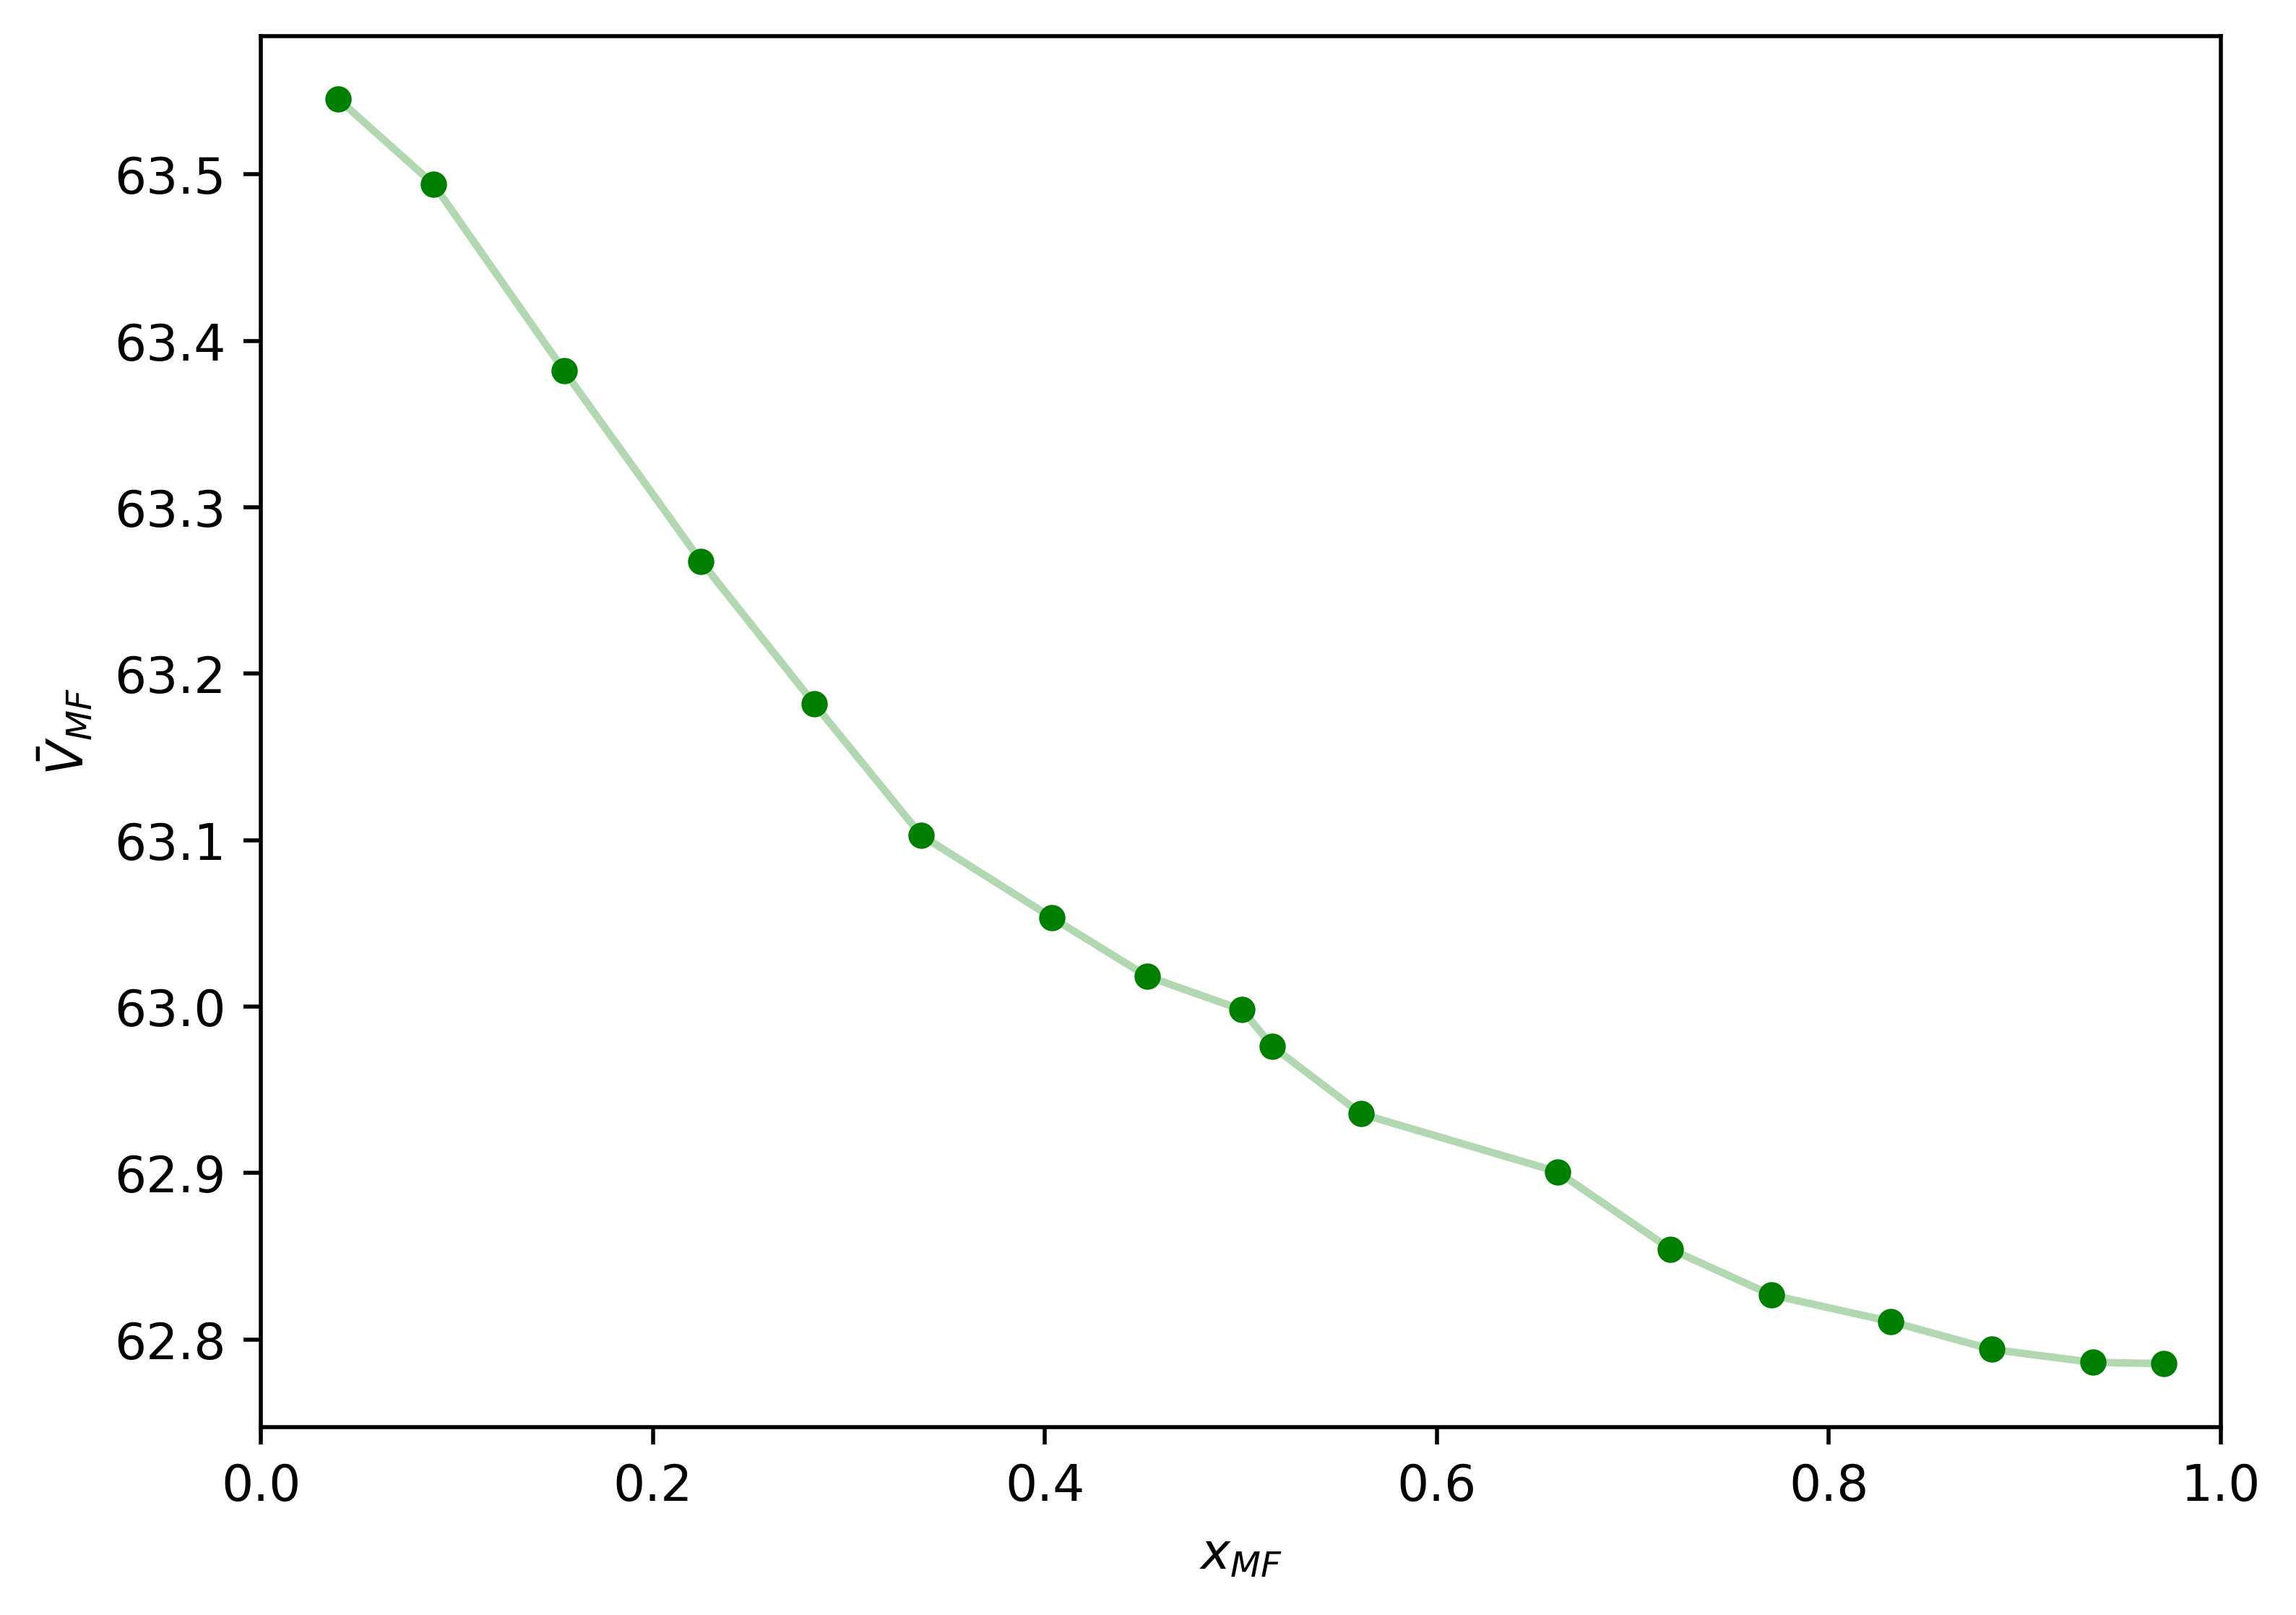

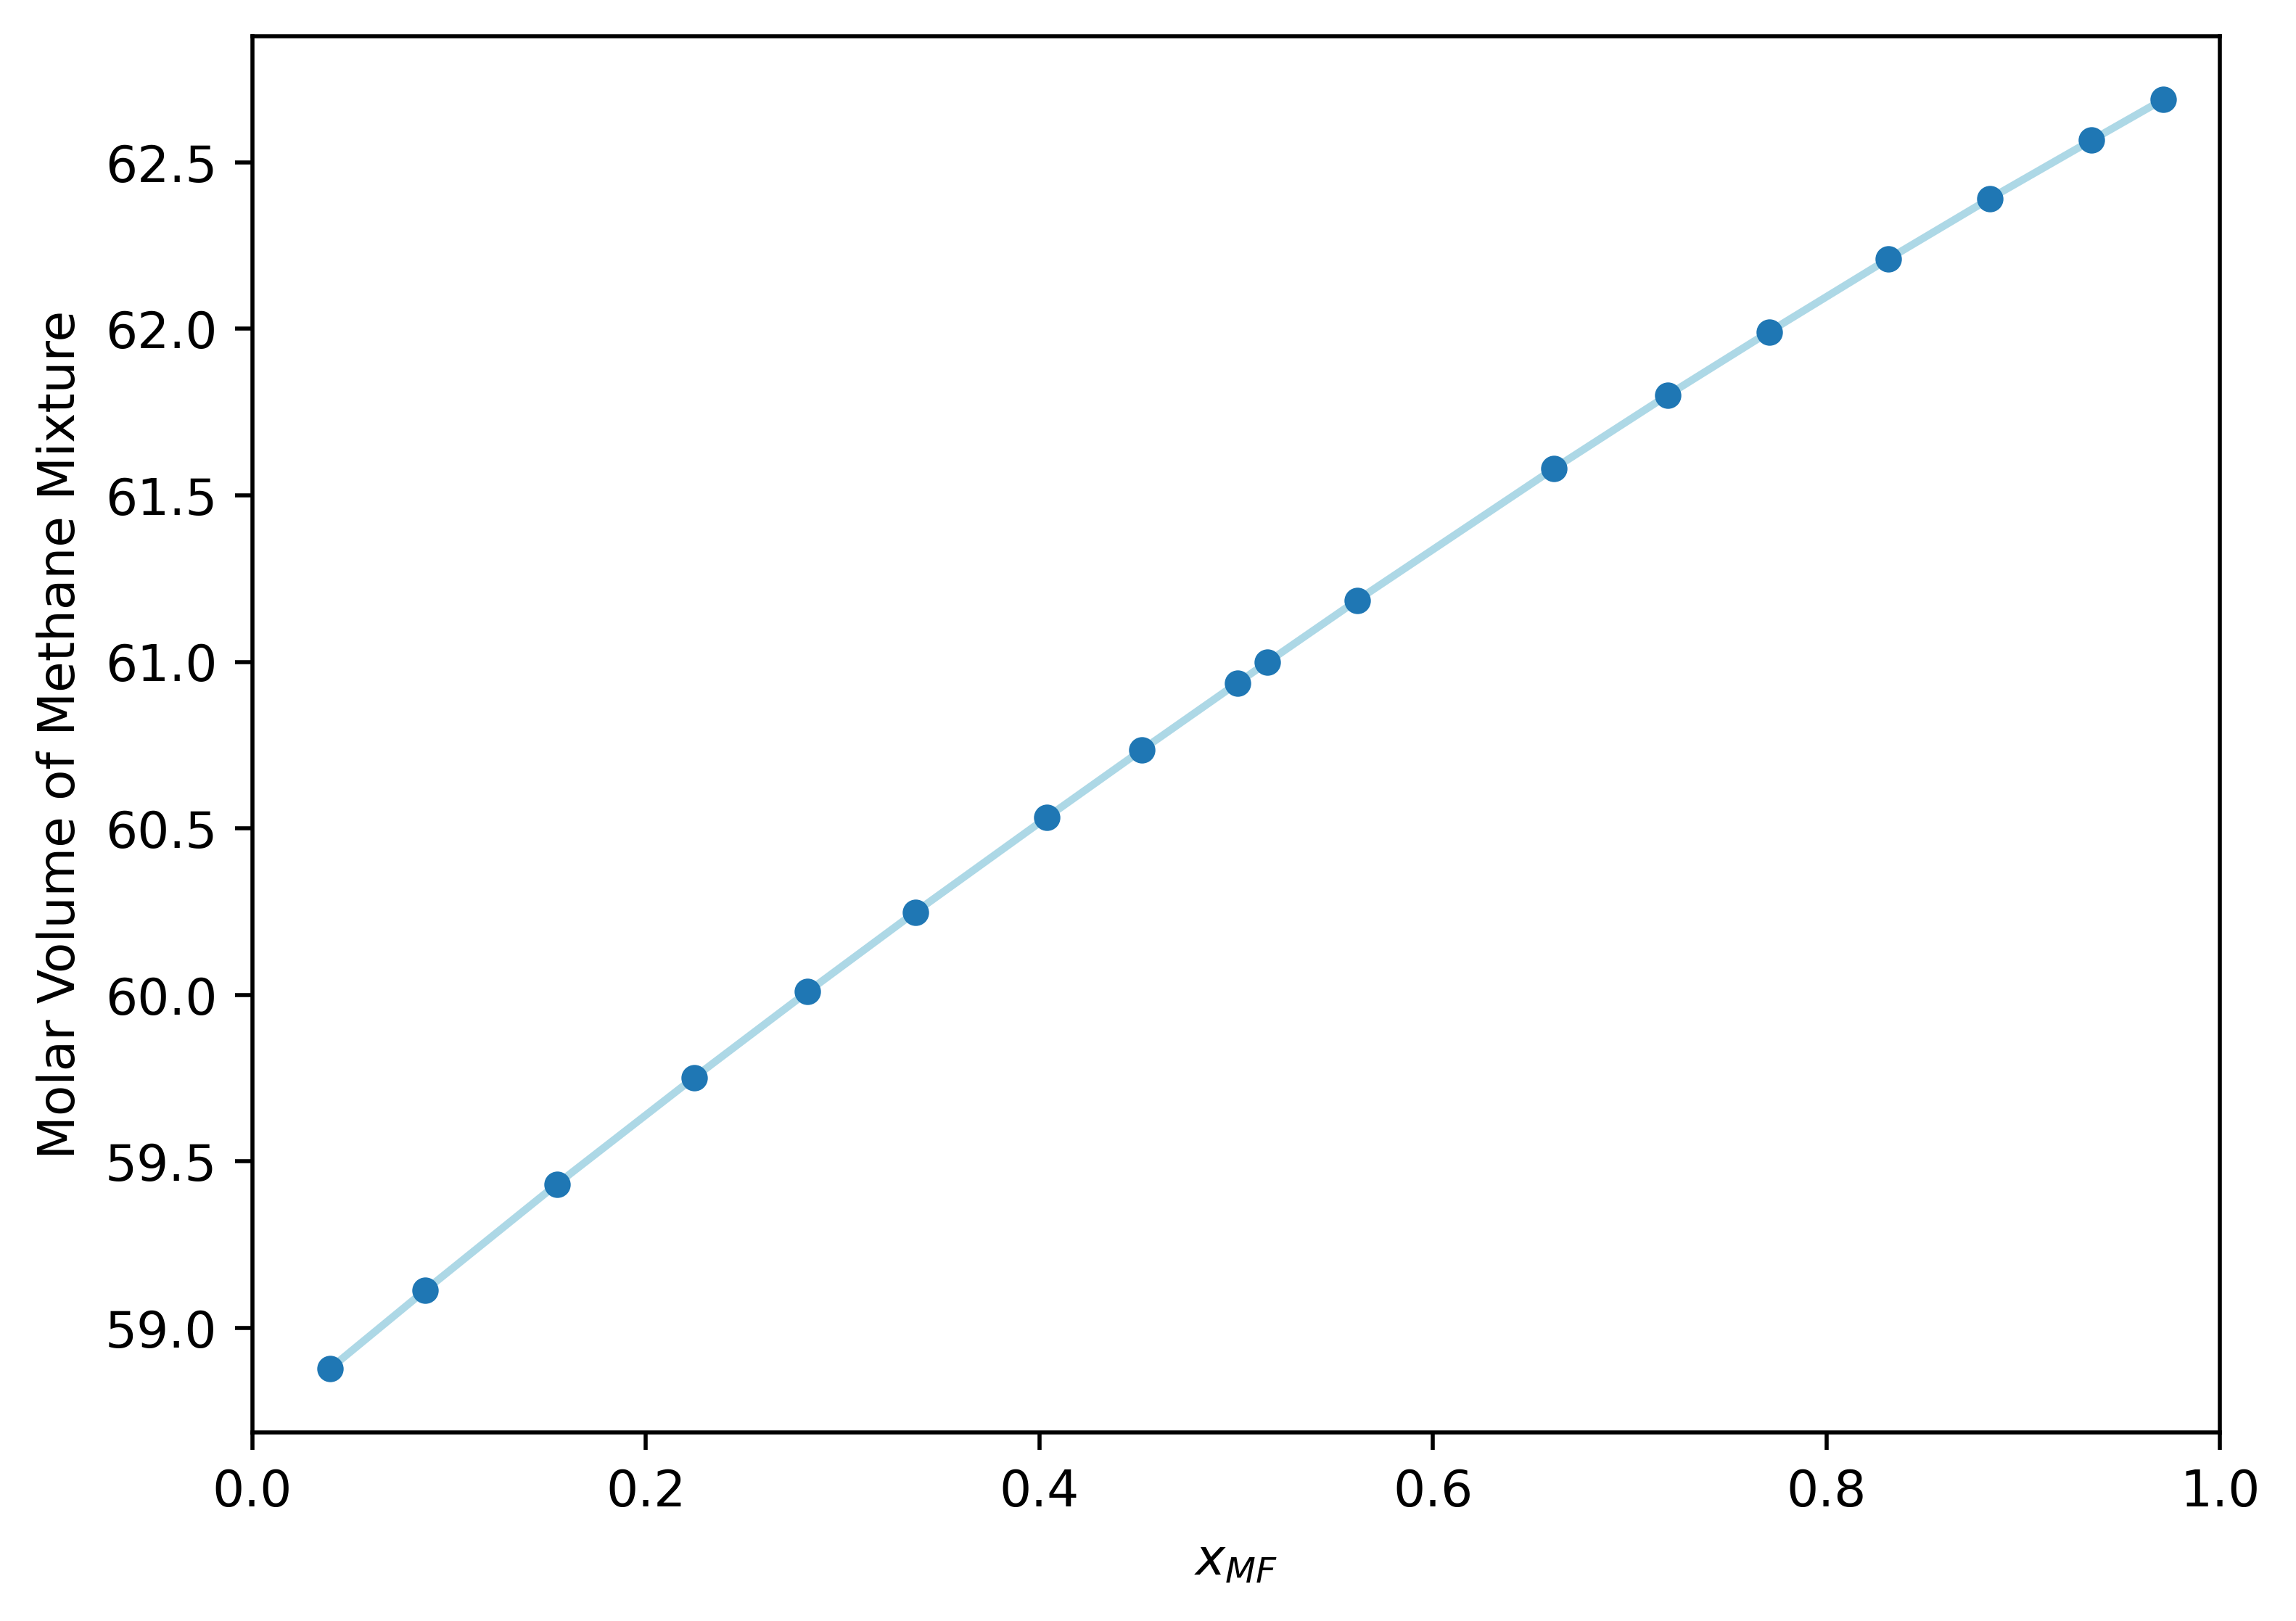

In [131]:
dpi = 500
fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"$\\bar{V}_{ethanol}$", 'xlim':(0,1)})
ax.scatter(x_mfe, pmv_e, c='red', s=18)
ax.plot(x_mfe, pmv_e, zorder=10, c='red', alpha=0.3);

fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"$\\bar{V}_{MF}$", 'xlim':(0,1)})
ax.scatter(x_mfe, pmv_mf, c='green', s=18)
ax.plot(x_mfe, pmv_mf, zorder=10, c='green', alpha=0.3);

fig,ax = plt.subplots(figsize=(7,5),dpi=dpi, subplot_kw={'xlabel':"$x_{MF}$", 'ylabel':"Molar Volume of Methane Mixture", 'xlim':(0,1)})
V = x_mfe * pmv_mf + (1-x_mfe) * pmv_e
ax.plot(x_mfe, V, c='lightblue')
ax.scatter(x_mfe, V, zorder=10, s=18);

In [132]:
# this is filler text. ignore.